<a href="https://colab.research.google.com/github/jeffvestal/bird_image_identifier/blob/main/bird_identifier_v2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What Kind of Bird is it?

# Setup

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
# Install latest fastai libs
!pip install -Uqq fastai

In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import fast.ai vision libs
from fastai.vision.all import *

## Download the Bird dataset

In [4]:
# https://docs.fast.ai/data.external.html#image-classification-datasets
path = untar_data(URLs.CUB_200_2011)

Dataset structure is like:

```
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/
Black_Footed_Albatross_0032_796115.jpg
```

the default `parent_label` func doesn't strip off the leading 001 from the bird type
 this func does that

`strip_parent_num(p)`

In [5]:
def strip_parent_num(o):
  return parent_label(o).split('.')[1]

## Download birds to test with

In [6]:
!pip install -Uqq duckduckgo_search


In [7]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): 
  return L(ddg_images(term, max_results=max_images)).itemgot('image')


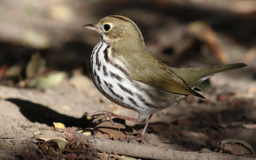

In [8]:
# Download Oven Bird photo
urls = search_images('oven bird photos', max_images=1)
urls[0]
     
from fastdownload import download_url
dest = 'oven-bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

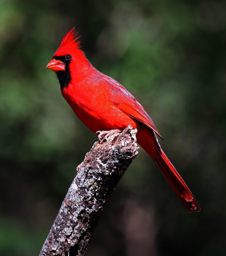

In [9]:
# Download Cardinal photo
urls = search_images('cardinal photos', max_images=1)
urls[0]
     
from fastdownload import download_url
dest = 'cardinal.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

# Training

## DataBlock - RandomResizedCrop - 192

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=strip_parent_num,
    item_tfms=RandomResizedCrop(192, min_scale=0.3)
).dataloaders(path, bs=32)

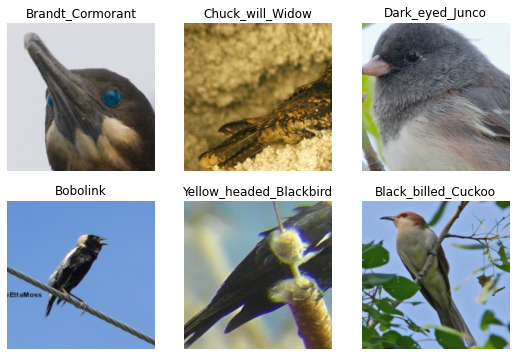

In [11]:
dls.show_batch(max_n=6)

### resnet18

#### 3 epochs

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.789104,2.397661,0.609673,01:24


epoch,train_loss,valid_loss,error_rate,time
0,2.376969,1.704550,0.450997,01:12
1,1.763696,1.297835,0.359779,01:09
2,1.347447,1.212653,0.334748,01:11


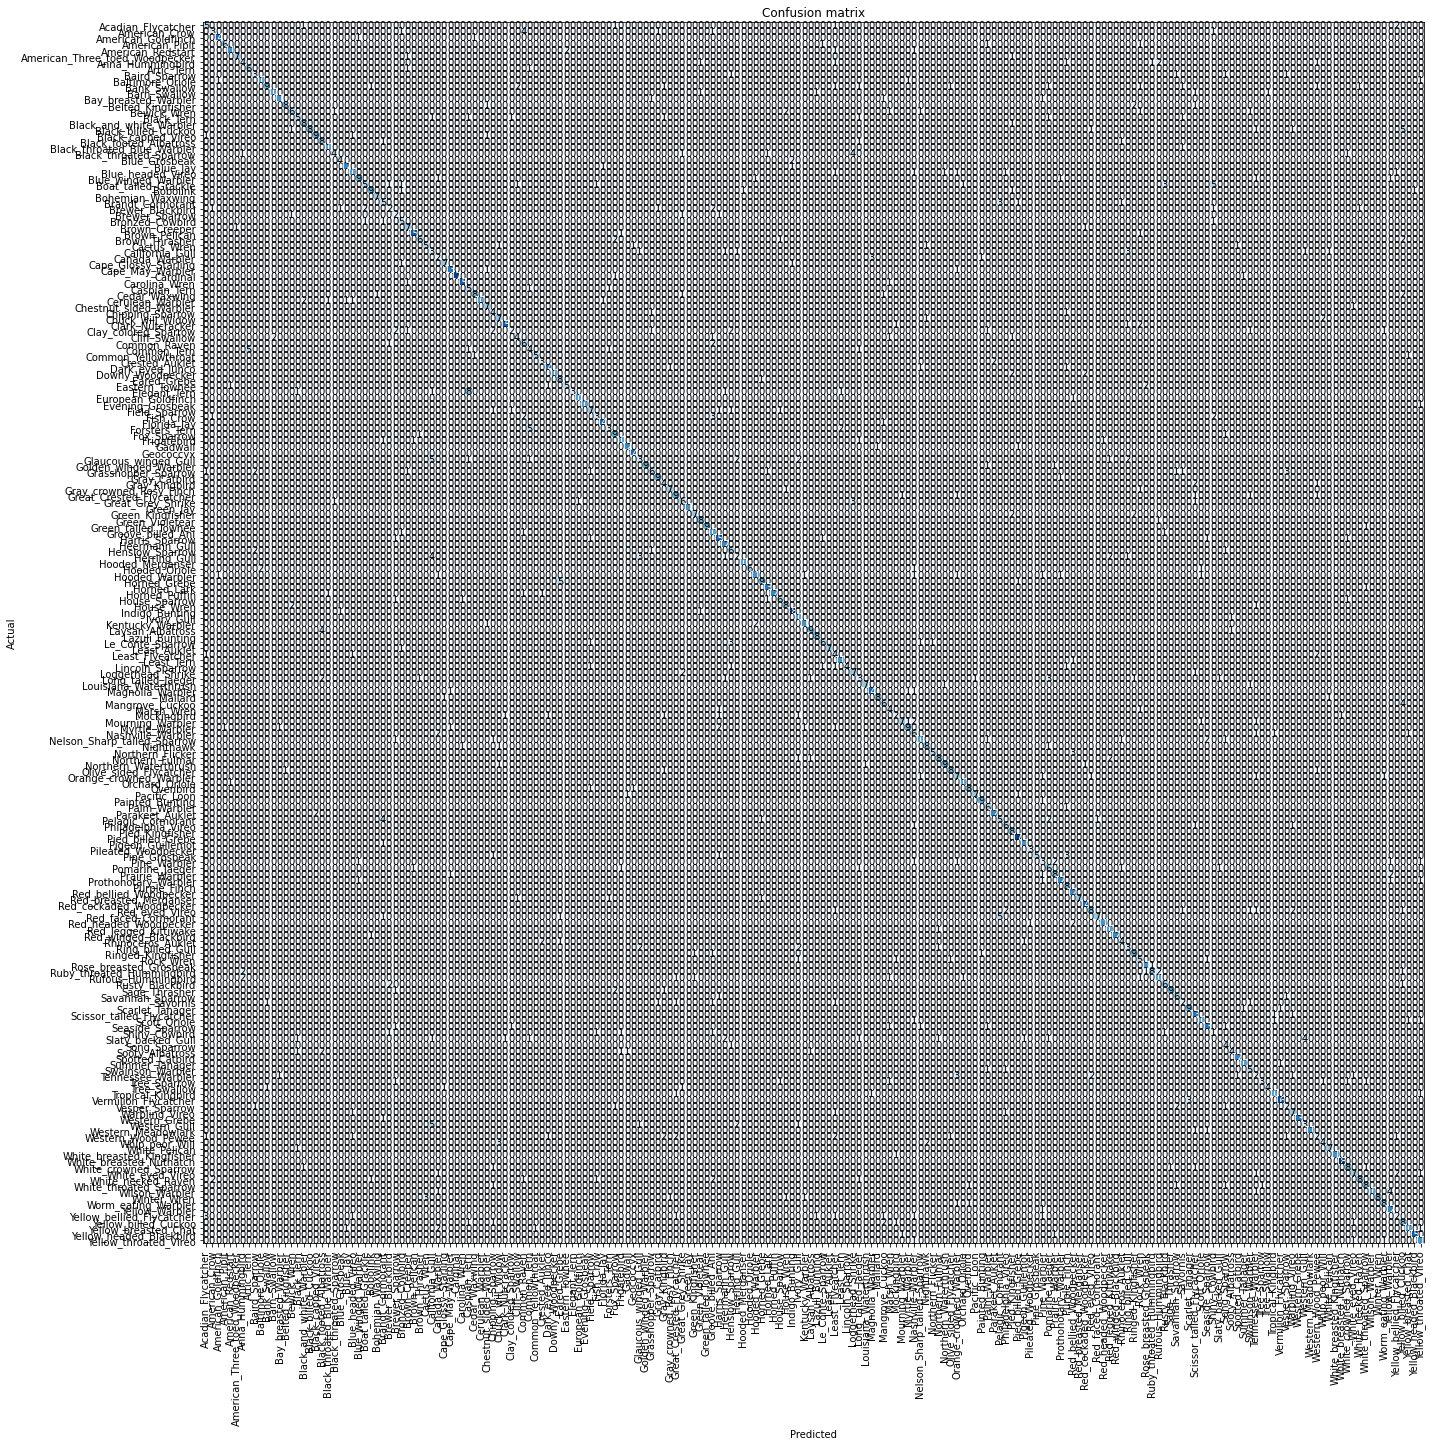

In [13]:
# Generate Confusion Matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(20,20))

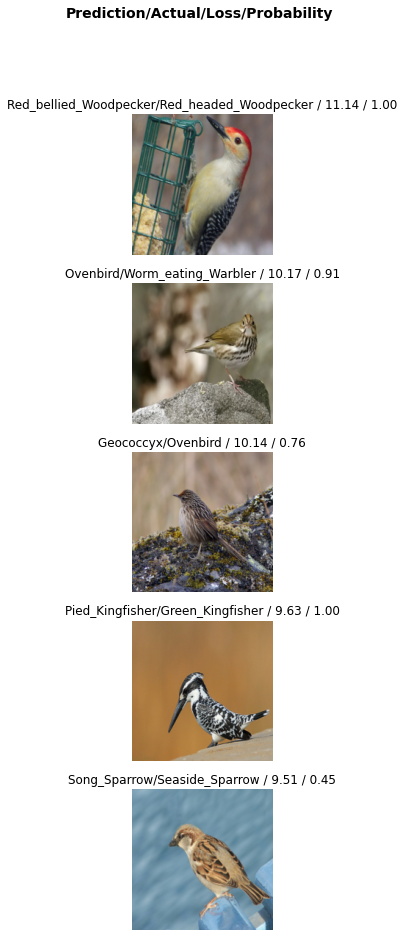

In [14]:
# Show Top losses

interp.plot_top_losses(5, nrows=5)

In [15]:
# Test againt samples
is_bird1,_,probs1 = learn.predict(PILImage.create('oven-bird.jpg'))
print(f"This is a: {is_bird1}.")
print(f"Probability it's a that: {probs1[0]:.10f}")
print()
is_bird2,_,probs2 = learn.predict(PILImage.create('cardinal.jpg'))
print(f"This is a: {is_bird2}.")
print(f"Probability it's a that: {probs2[0]:.10f}")

This is a: Ovenbird.
Probability it's a that: 0.0000450987



This is a: Cardinal.
Probability it's a that: 0.0000001704


### resnet34

#### 3 epochs

In [16]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.701467,2.228475,0.566398,01:13


epoch,train_loss,valid_loss,error_rate,time
0,2.300227,1.559376,0.423844,01:14
1,1.565366,1.121332,0.318201,01:14
2,1.101641,1.022557,0.287654,01:14


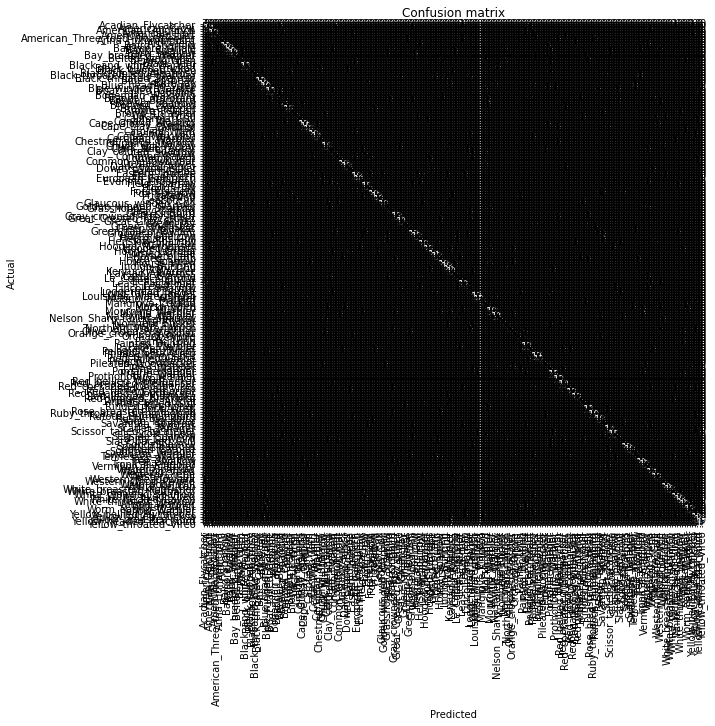

In [17]:
# Generate Confusion Matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

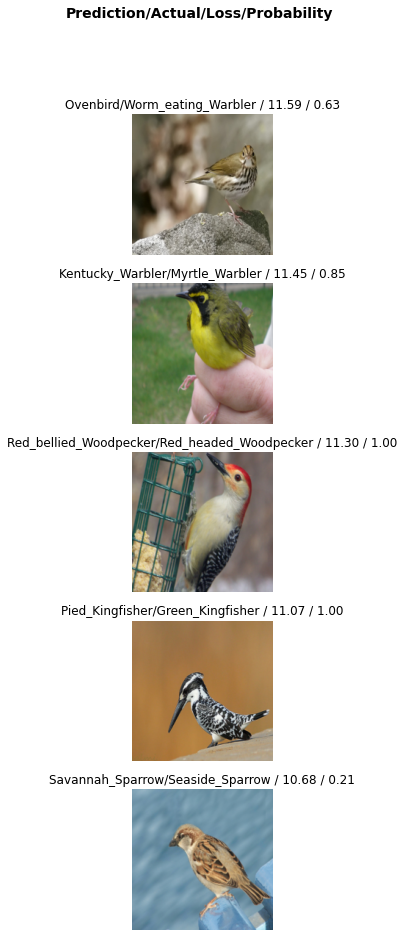

In [18]:
# Show Top losses

interp.plot_top_losses(5, nrows=5)

In [20]:
# Test againt samples
is_bird1,_,probs1 = learn.predict(PILImage.create('oven-bird.jpg'))
print(f"This is a: {is_bird1}.")
print(f"Probability it's a that: {probs1[0]:.10f}")
print()
is_bird2,_,probs2 = learn.predict(PILImage.create('cardinal.jpg'))
print(f"This is a: {is_bird2}.")
print(f"Probability it's a that: {probs2[0]:.10f}")

This is a: Ovenbird.
Probability it's a that: 0.0009947249



This is a: Cardinal.
Probability it's a that: 0.0000011443


**Notes**

Test results seemed good, little better than resnet18, as expected with basically the same training time / epoch

Error rate on training is really high @ 30%

-- need to try cleaning some of the data to delete the highest error bird training samples

### convnext model


Need to install timm lib for extra models

List out available models for convnext*

[Which Models are Best - Plot speed v accuracy notbook](https://)

In [12]:
import timm

In [14]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

### convnext_tiny_in22k

#### 3 epochs

In [15]:
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.605810,0.750354,0.191345,01:39


epoch,train_loss,valid_loss,error_rate,time
0,0.881423,0.567448,0.154434,03:11
1,0.731202,0.482746,0.133220,03:12
2,0.504811,0.454295,0.120916,03:14


In [ ]:
# Generate Confusion Matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(20,20))

In [ ]:
# Show Top losses

interp.plot_top_losses(5, nrows=5)

In [17]:
# Test againt samples
is_bird1,_,probs1 = learn.predict(PILImage.create('oven-bird.jpg'))
print(f"This is a: {is_bird1}.")
print(f"Probability it's a that: {probs1[0]:.10f}")
print()
is_bird2,_,probs2 = learn.predict(PILImage.create('cardinal.jpg'))
print(f"This is a: {is_bird2}.")
print(f"Probability it's a that: {probs2[0]:.10f}")

This is a: Ovenbird.
Probability it's a that: 0.0000030182



This is a: Cardinal.
Probability it's a that: 0.0000000005


**Notes**

vs resnet34

This model gave a much better error rate after 3 epochs - 12% vs 29%

Downside is it takes 3min / epoch to train vs 1min 

Probability for test samples far superior also cardinal - 0.0000000005 vs 0.0000011443

### convnext_small_in22k

#### 3 epochs

In [18]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.453225,0.666782,0.189648,02:36


epoch,train_loss,valid_loss,error_rate,time
0,0.834763,0.497028,0.144251,05:00
1,0.606030,0.422649,0.116674,05:02
2,0.431926,0.393372,0.102249,05:02


In [ ]:
# Generate Confusion Matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(20,20))

In [ ]:
# Show Top losses

interp.plot_top_losses(5, nrows=5)

In [19]:
# Test againt samples
is_bird1,_,probs1 = learn.predict(PILImage.create('oven-bird.jpg'))
print(f"This is a: {is_bird1}.")
print(f"Probability it's a that: {probs1[0]:.10f}")
print()
is_bird2,_,probs2 = learn.predict(PILImage.create('cardinal.jpg'))
print(f"This is a: {is_bird2}.")
print(f"Probability it's a that: {probs2[0]:.10f}")

This is a: Ovenbird.
Probability it's a that: 0.0000039194



This is a: Cardinal.
Probability it's a that: 0.0000000265


**Notes**

vs convnext_tiny_in22k

This model gave 18% better error rate after 3 epochs - 0.102249 vs 0.120916

Downside is it takes 60% longer 5min / epoch to train vs 3min 

Probability for test samples far superior also cardinal - 0.0000000005 vs 0.0000011443

In [22]:
learn.export('birds-convnext_small_in22k.pkl')

#### 6 epochs

In [23]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.408683,0.756293,0.207043,02:35


epoch,train_loss,valid_loss,error_rate,time
0,0.769831,0.462271,0.128129,05:00
1,0.688047,0.465433,0.130250,05:01
2,0.595006,0.445719,0.123886,05:00
3,0.460503,0.419755,0.110734,05:00
4,0.357143,0.386027,0.102249,05:01
5,0.280733,0.385738,0.103097,05:00


In [ ]:
# Generate Confusion Matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(20,20))

In [ ]:
# Show Top losses

interp.plot_top_losses(5, nrows=5)

In [24]:
# Test againt samples
is_bird1,_,probs1 = learn.predict(PILImage.create('oven-bird.jpg'))
print(f"This is a: {is_bird1}.")
print(f"Probability it's a that: {probs1[0]:.10f}")
print()
is_bird2,_,probs2 = learn.predict(PILImage.create('cardinal.jpg'))
print(f"This is a: {is_bird2}.")
print(f"Probability it's a that: {probs2[0]:.10f}")

This is a: Ovenbird.
Probability it's a that: 0.0000002440



This is a: Cardinal.
Probability it's a that: 0.0000000201


**Notes**

vs 6 epochs vs 3

This model gave a little worse error on the 6th epoch, looks like it may have started to overtrain after 5 epochs

Probability for test samples far superior also cardinal - 0.0000000201 vs 0.0000000265

In [27]:
0.0000000201 - 0.0000000265

-6.399999999999998e-09

In [25]:
learn.export('birds-convnext_small_in22k_6epochs.pkl')